In [1]:
%load_ext line_profiler

In [2]:
import jax.numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed as set_seed, randint
from scipy import stats
from jax.interpreters.xla import DeviceArray
from jax import grad, jit

plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'Dark2'

# Definitions

In [3]:
def classify_with_hyperplane(X, w) -> '(X.shape[0],)':
    return np.sign(X @ w)

def classify_with_tiles(X, B, c) -> '(X.shape[0],)':
    tiles = (X[:, :, np.newaxis] > B[np.newaxis, :, :]).sum(axis=2)
    tiles_flat = tiles @ np.array([(k+1)**i for i in range(d)])
    return c[tiles_flat] 

def sigmoid(x) -> 'x.shape':
    return 1/(1 + np.exp(-x))

def make_normal_unit_vector(d) -> '(d,)':
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)

def add_seperation(X, sep=0) -> 'X: (N, d); y: (N,)':
    d = X.shape[1]
    w = make_normal_unit_vector(d)
    y = np.sign(X @ w)
    X += sep*y[:, np.newaxis]*w
    return X, y

def generate_random_boundaries(X, d, k) -> '(d, k)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    sample = lambda: np.array(dist.rvs(size=(1, k))).sort()
    return np.concatenate([sample() for _ in range(d)])

def generate_random_reconstruction_points(X, M, d) -> '(M, d)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    return dist.rvs(size=(M, d))

def plot_2d_problem(X, y=None, B=None, RX=None):
    x = np.linspace(X.min(), X.max(), 100)
    plt.scatter(*X.T, c=y, alpha=0.25)
    plt.plot(x, x, 'k--', alpha=0.15)
    if B is not None:
        plt.vlines(B[0], X[:, 1].min(), X[:, 1].max(),
                   colors='k', linestyles='dashed')
        plt.hlines(B[1], X[:, 0].min(), X[:, 0].max(),
                   colors='k', linestyles='dashed')
        
    if RX is not None:
        plt.scatter(*RX.T, s=100, marker='X', c='black')
    
def calc_tile_centroids(B, X) -> '(M, d)':
    B_ = np.hstack([X.min(axis=0)[:, np.newaxis],
                    B,
                    X.max(axis=0)[:, np.newaxis]])
    RX = (B_[:, :-1] + B_[:, 1:])/2
    return np.stack(np.meshgrid(*RX), axis=-1).reshape(-1, X.shape[1])

def calc_min_reconstruction_tiling(RX) -> '(M, d)':
    d = RX.shape[1]
    R = int(np.log2(RX.shape[0])/d)
    Z_coords = sort_dimensions(RX).reshape(2**R, -1, d).mean(axis=1).T
    return np.stack(np.meshgrid(*Z_coords), axis=2).reshape(-1, d), Z_coords

def calc_boundaries_from_tile_centroids(Z_coords) -> '(d, k)':
    return (Z_coords[:, 1:] + Z_coords[:, :-1])/2

def sort_dimensions(A) -> '(*A.shape)':
    return A[A.argsort(axis=0), np.arange(A.shape[1])]

def find_closest_rpoints_index(X, Z) -> '(N,)':
    return np.power(X[:, np.newaxis] - Z, 2).sum(axis=2).argmin(axis=1)

# def calc_best_rpoints(X, Qinv, RX=None) -> '(M, d)':
#     if RX is not None:
#         X = np.concatenate((X, RX), axis=0)
#         Qinv = np.concatenate((Qinv, np.arange(RX.shape[0])))
#     count_per_region = np.unique(Qinv, return_counts=True)[1]
#     tiled_points = np.split(X[Qinv.argsort()], count_per_region.cumsum()[:-1])
#     return np.array([region.mean(axis=0) for region in tiled_points])

def calc_best_rpoints(X, Qinv, RX=None) -> '(M, d)':
    if RX is not None:
        X = np.concatenate((X, RX), axis=0)
        Qinv = np.concatenate((Qinv, np.arange(RX.shape[0])))
    return np.array([X[Qinv == i].mean(axis=0) for i in range(M)])

In [4]:
seed: 'global numpy seed' = 20
set_seed(seed)

N: 'sample size' = 2_000
d: 'problem dimension' = 2
R: 'bit rate per dimension' = 2
X: 'sample' = (stats
               .multivariate_normal(mean=stats.uniform().rvs(10*d),
                                    cov=1e-2)
               .rvs(size=int(N/10))
               .reshape(-1, d))
X, y = add_seperation(X, 0.05)
w: 'unit vector normal to class. boundary (d,)' = make_normal_unit_vector(d)
k: 'number of boundaries (roots) per dimension' = 2**R - 1
M: 'number of tiles' = 2**(R*d)
RX: 'reconstruction points (M,)' = generate_random_reconstruction_points(X, M, d)
Z, Z_coords = calc_min_reconstruction_tiling(RX)
B: 'boundaries matrix (d, k)' = calc_boundaries_from_tile_centroids(Z_coords)
c: 'label of each tile (M,)' = classify_with_hyperplane(Z, w)

/home/dsevero/miniconda3/envs/dsevero.com/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# 2D Problem

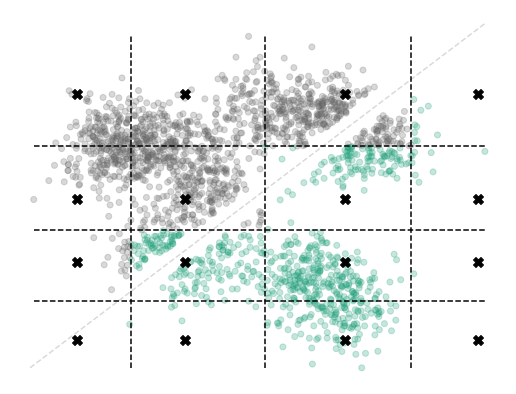

In [8]:
plt.figure(figsize=(9, 7))
y_tile = classify_with_tiles(X, B, c)
plot_2d_problem(X, y_tile, B, Z)
# plt.scatter(*Z.T, s=100, c='blue')
plt.axis('off');

# Tiled Lloyd-max Quantization

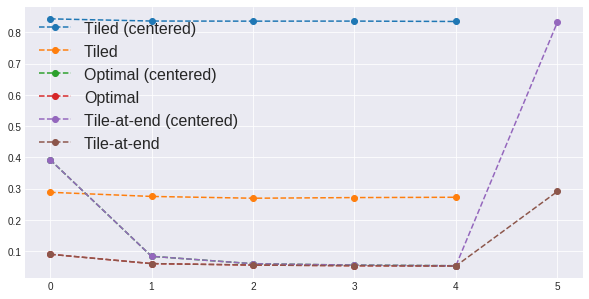

In [6]:
def calc_reconstruction_loss(X, Z, Qinv):
    return np.power(X - Z[Qinv], 2).sum(axis=1).mean()

def tiled_lloyd_max_quantization(X, M, max_iter=200, should_tile=True):
    seed: 'global numpy seed' = 1
    set_seed(seed)
    d = X.shape[1]
    RX = generate_random_reconstruction_points(X, M, d)
    for i in range(max_iter):
        if should_tile:
            Z, Z_coords = calc_min_reconstruction_tiling(RX)
        else:
            Z, Z_coords = RX, None

        Qinv = find_closest_rpoints_index(X, Z)
        RX = calc_best_rpoints(X, Qinv, RX)
        
        if should_tile:
            B = calc_boundaries_from_tile_centroids(Z_coords)
        else:
            B = None

        yield RX, Z, Qinv
        
def tile_at_end_lloyd_max_quantization(X, M, max_iter=200):
    for RX, Z, Qinv in tiled_lloyd_max_quantization(X, M, max_iter, False):
        yield RX, Z, Qinv
    Z, _ = calc_min_reconstruction_tiling(RX)
    Qinv = find_closest_rpoints_index(X, Z)
    RX = calc_best_rpoints(X, Qinv, RX)
    yield RX, Z, Qinv

N: 'sample size' = 200
d: 'problem dimension' = 10
R: 'bit rate per dimension' = 1
X: 'sample' = (stats
               .multivariate_normal(mean=stats.uniform().rvs(10*d),
                                    cov=1e-2)
               .rvs(size=int(N/10))
               .reshape(-1, d))
M: 'number of tiles' = 2**(R*d)
max_iter = 5

X, y = add_seperation(X, 0.05)
        
loss_tiled_recon = [(calc_reconstruction_loss(X, Z, Qinv),
                     calc_reconstruction_loss(X, RX, Qinv))
                    for RX, Z, Qinv in tiled_lloyd_max_quantization(X, M, max_iter, True)]

loss_lloyd_recon = [(calc_reconstruction_loss(X, Z, Qinv),
                     calc_reconstruction_loss(X, RX, Qinv))
                    for RX, Z, Qinv in tiled_lloyd_max_quantization(X, M, max_iter, False)]

loss_tiend_recon = [(calc_reconstruction_loss(X, Z, Qinv),
                     calc_reconstruction_loss(X, RX, Qinv))
                    for RX, Z, Qinv in tile_at_end_lloyd_max_quantization(X, M, max_iter)]

plt.figure(figsize=(10,5))
plt.plot([l[0] for l in loss_tiled_recon], 'o--')
plt.plot([l[1] for l in loss_tiled_recon], 'o--')
plt.plot([l[0] for l in loss_lloyd_recon], 'o--')
plt.plot([l[1] for l in loss_lloyd_recon], 'o--')
plt.plot([l[0] for l in loss_tiend_recon], 'o--')
plt.plot([l[1] for l in loss_tiend_recon], 'o--')
plt.legend(['Tiled (centered)', 'Tiled',
            'Optimal (centered)', 'Optimal',
            'Tile-at-end (centered)', 'Tile-at-end'], fontsize=16)
plt.show()

The chart above is the reconstruction loss ($\gamma=0$)
- Optimal (centered): Classic Lloyd-max reconstruction points.
- Optimal: Same as the centered version.
- Tiled (centered): At each interation, calculate the tile-inducing reconstruction points closest to Optimal and use it for the next iteration.
- **Tiled: Same as Tiled (centered) but with an extra step at each iteration: calculate the tile centroids and use that for reconstruction (but let the centered points define the quantization regions). Note that here we have 2 sets of points, one for reconstruction and one for mapping sample points on to**
- Tile-at-end (centered): Run the optimal Lloyd-max quantizer and calculate the tile-inducing reconstruction points as an extra step at the end (the idea here was to see if we needed to calculate the tile-inducing points at each iteration or just postpone it till the end).